In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# Import Data
X_train_np = np.load("../VAE_Data/X_train.npy", allow_pickle=True).astype(np.float64)
X_test_np = np.load("../VAE_data/X_test.npy", allow_pickle=True).astype(np.float64)
y_train_np = np.load("../VAE_data/y_train.npy", allow_pickle=True).astype(np.float64)
y_test_np = np.load("../VAE_Data/y_test.npy", allow_pickle=True).astype(np.float64)

X_train_np.shape, X_test_np.shape, y_train_np.shape, y_test_np.shape

((14196, 2640), (1586, 2640), (14196, 1890), (1586, 1890))

In [3]:
# Combine train and test data for scaling
X_combined = np.vstack((X_train_np, X_test_np))
y_combined = np.vstack((y_train_np, y_test_np))

# Scale the Data
scaler = StandardScaler()
X_scaled = X_combined.copy()
X_scaled[:, 749:] = scaler.fit_transform(X_combined[:, 749:])

ordinal_days_scaler = MinMaxScaler()
X_scaled[:, 748] = ordinal_days_scaler.fit_transform(X_combined[:, 748].reshape(-1, 1)).ravel()

# Scale y values
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y_combined)

# Split the scaled data back into train and test sets
X_train_scaled = X_scaled[:len(X_train_np)]
X_test_scaled = X_scaled[len(X_train_np):]
y_train_scaled = y_scaled[:len(y_train_np)]
y_test_scaled = y_scaled[len(y_train_np):]


In [4]:
X_train_scaled.shape, X_test_scaled.shape, y_train_scaled.shape, y_test_scaled.shape

((14196, 2640), (1586, 2640), (14196, 1890), (1586, 1890))

In [5]:
# Define the encoder
latent_dim = 256 
encoder_inputs = keras.Input(shape=(2640,))
x = layers.Dense(2048, activation="relu")(encoder_inputs)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Define the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(512, activation="relu")(latent_inputs)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dense(1600, activation="relu")(x)
decoder_outputs = layers.Dense(1890, activation="linear")(x)  # Match your y shape
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Define the VAE model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta  # Add beta as an attribute
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.val_total_loss_tracker = keras.metrics.Mean(name="val_loss")
        self.val_reconstruction_loss_tracker = keras.metrics.Mean(name="val_reconstruction_loss")
        self.val_kl_loss_tracker = keras.metrics.Mean(name="val_kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.val_total_loss_tracker,
            self.val_reconstruction_loss_tracker,
            self.val_kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def compute_loss(self, x, y):
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.mse(y, reconstruction), axis=-1
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + self.beta * kl_loss  # Apply beta to KL loss
        return total_loss, reconstruction_loss, kl_loss

    def train_step(self, data):
        if isinstance(data, tuple):
            x, y = data
        else:
            x = y = data

        with tf.GradientTape() as tape:
            total_loss, reconstruction_loss, kl_loss = self.compute_loss(x, y)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            x, y = data
        else:
            x = y = data

        total_loss, reconstruction_loss, kl_loss = self.compute_loss(x, y)

        self.val_total_loss_tracker.update_state(total_loss)
        self.val_reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.val_kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.val_total_loss_tracker.result(),
            "reconstruction_loss": self.val_reconstruction_loss_tracker.result(),
            "kl_loss": self.val_kl_loss_tracker.result(),
        }

In [6]:
# Instantiate the VAE model
vae = VAE(encoder, decoder, beta=1)

# Compile the model
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [7]:
# Assuming X_train_scaled and y_train_scaled are your preprocessed datasets
# Train the model
history = vae.fit(
    X_train_scaled, 
    y_train_scaled, 
    epochs=100, 
    batch_size=1024, 
    validation_data=(X_test_scaled, y_test_scaled),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - kl_loss: 42.7181 - loss: 932.3000 - reconstruction_loss: 889.5820 - val_kl_loss: 4.6037 - val_loss: 1598.8594 - val_reconstruction_loss: 1594.2556 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - kl_loss: 15.2994 - loss: 894.1671 - reconstruction_loss: 878.8676 - val_kl_loss: 2.3899 - val_loss: 1598.0232 - val_reconstruction_loss: 1595.6333 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - kl_loss: 1017.4988 - loss: 1895.3921 - reconstruction_loss: 877.8933 - val_kl_loss: 1.9001 - val_loss: 1597.3558 - val_reconstruction_loss: 1595.4557 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - kl_loss: 78.5246 - loss: 937.5496 - reconstruction_loss: 859.0250 - val_kl_loss: 2.2965 - val_loss: 1598.4381 - val_reconstruction_loss: 1596.1416 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - kl_loss: 11.4203 - loss: 904.0626 - re

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 1.7486 - loss: 63.8947 - reconstruction_loss: 62.1461
Test Total Loss: 65.6895
Test Reconstruction Loss: 63.8175
Test KL Loss: 1.8720
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
    Sample  Feature  True Value  Predicted Value   Difference
0        1        1         0.0        17.570696   -17.570696
1        1        2         0.0         1.698034    -1.698034
2        1        3         0.0        54.577450   -54.577450
3        1        4         0.0         2.478797    -2.478797
4        1        5         0.0         0.007653    -0.007653
..     ...      ...         ...              ...          ...
95       5       16         0.0      2782.638428 -2782.638428
96       5       17         0.0         0.056891    -0.056891
97       5       18         0.0        19.760620   -19.760620
98       5       19         0.0       617.821106  -617.821106
99       5       20         0.0       154.871719  -154.871719

[100 rows x 5 columns]


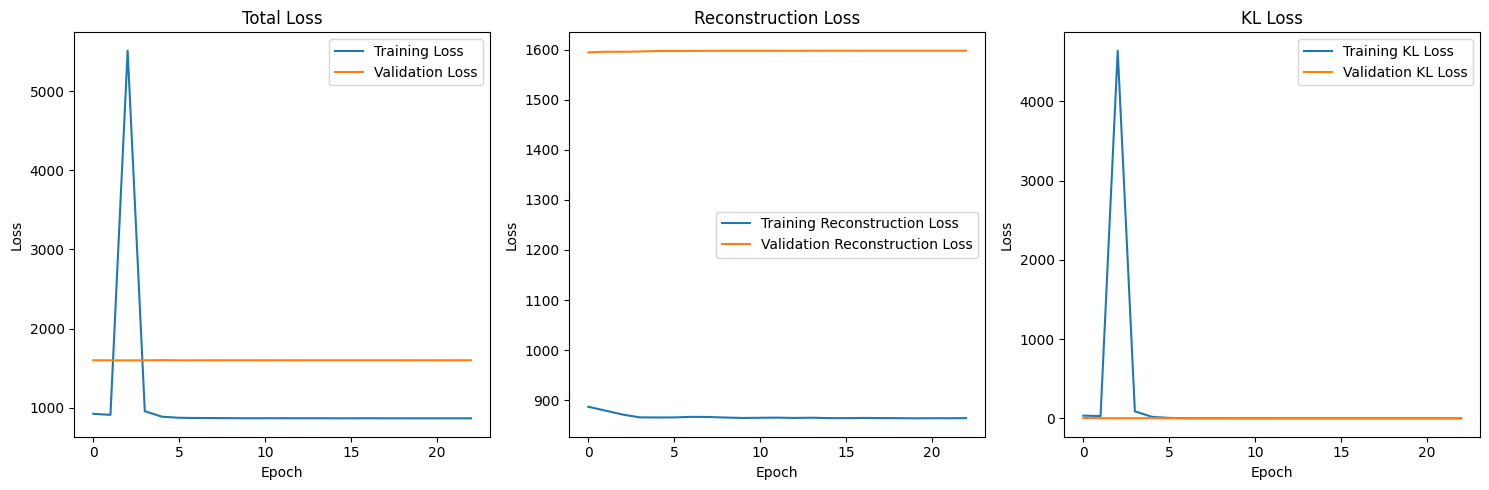

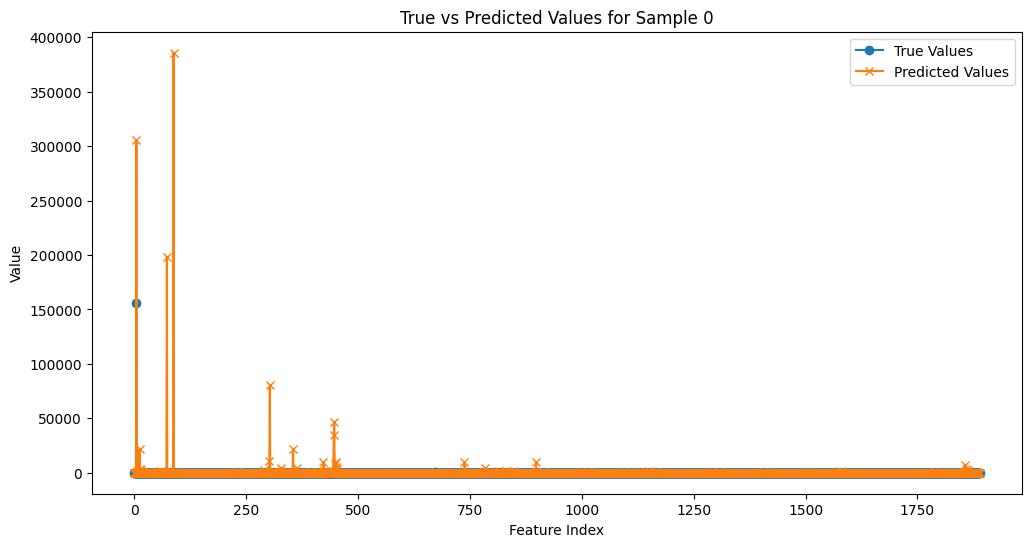

Overall MAE: 1431.0270


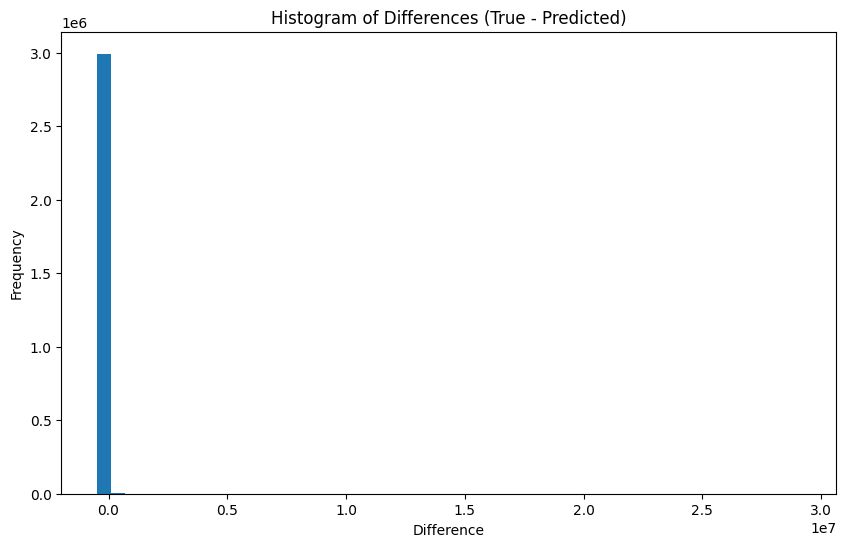

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


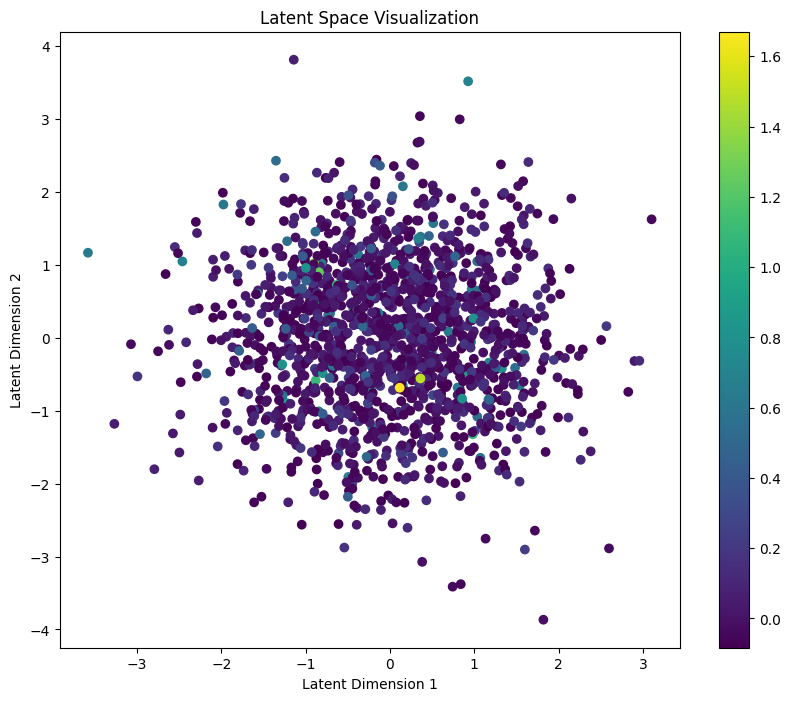

In [9]:
# Evaluate the model
test_metrics = vae.evaluate(X_test_scaled, y_test_scaled)

# Assuming the metrics are in the order: [total_loss, reconstruction_loss, kl_loss]
print(f"Test Total Loss: {test_metrics[0]:.4f}")
print(f"Test Reconstruction Loss: {test_metrics[1]:.4f}")
print(f"Test KL Loss: {test_metrics[2]:.4f}")

# Get predictions
y_pred_scaled = vae.predict(X_test_scaled)

# Inverse scale predictions and true values
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test_scaled)

# Create a sample dataframe
sample_size = 5  # Number of samples to show
sample_features = 20  # Number of features to show for each sample
sample_data = []
for i in range(sample_size):
    true_vals = y_true[i][:sample_features]
    pred_vals = y_pred[i][:sample_features]
    diff = true_vals - pred_vals
    for j in range(sample_features):
        sample_data.append({
            'Sample': i+1,
            'Feature': j+1,
            'True Value': true_vals[j],
            'Predicted Value': pred_vals[j],
            'Difference': diff[j]
        })
df_sample = pd.DataFrame(sample_data)
print(df_sample)

# Plot training history
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['reconstruction_loss'], label='Training Reconstruction Loss')
plt.plot(history.history['val_reconstruction_loss'], label='Validation Reconstruction Loss')
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['kl_loss'], label='Training KL Loss')
plt.plot(history.history['val_kl_loss'], label='Validation KL Loss')
plt.title('KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot true vs predicted values for a single sample
sample_index = 0  # Change this to view different samples
plt.figure(figsize=(12, 6))
plt.plot(y_true[sample_index], label='True Values', marker='o')
plt.plot(y_pred[sample_index], label='Predicted Values', marker='x')
plt.title(f'True vs Predicted Values for Sample {sample_index}')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()
plt.show()

# Calculate and print overall MAE
overall_mae = np.mean(np.abs(y_true - y_pred))
print(f"Overall MAE: {overall_mae:.4f}")

# Plot histogram of differences
differences = y_true - y_pred
plt.figure(figsize=(10, 6))
plt.hist(differences.flatten(), bins=50)
plt.title('Histogram of Differences (True - Predicted)')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

# Plot latent space (if you want to visualize the encoded representations)
_, _, z = vae.encoder.predict(X_test_scaled)
plt.figure(figsize=(10, 8))
plt.scatter(z[:, 0], z[:, 1], c=y_test_scaled.mean(axis=1), cmap='viridis')
plt.colorbar()
plt.title('Latent Space Visualization')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()